# Using Support Vector Machine

## Configuration:

* Linear Kernel

## Parameters:

* Learning Rate: 0.0005
* Training Epochs: 5000
* Regularization: 0.01
* svmC = 1

             precision    recall  f1-score   support

       -1.0       0.23      0.80      0.36        15
        1.0       0.98      0.77      0.86       172

avg / total       0.92      0.77      0.82       187

Sensitivity is 0.800
Specificity is 0.767


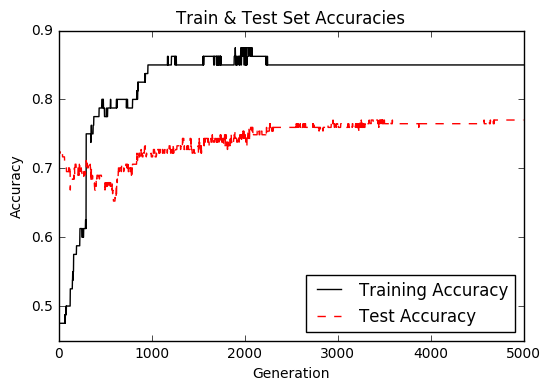

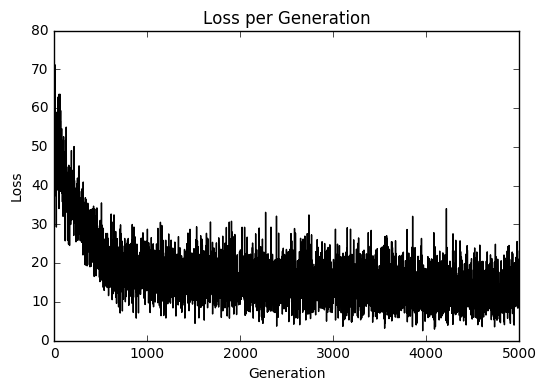

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.python.framework import ops

def extract_data(filename):

    out = np.loadtxt(filename, delimiter=',');

    # Arrays to hold the labels and feature vectors.
    labels = out[:,0]
    labels = labels.reshape(labels.size,1)
    fvecs = out[:,1:]

    # Return a pair of the feature matrix and the one-hot label matrix.
    return fvecs,labels

def formulate_data(filename):

    # Extract data
    data, labels = extract_data(filename)

    # Convert labels {-1, 1}
    tmp  = labels

    labels[labels==0] = -1

    # Get the shape
    size, num_features = data.shape

    return (data, tmp, labels, size, num_features)

def main(argv=None):

    # Get the formulated data & information

    train_data_filename = '../data/SPECT.train.txt'
    test_data_filename = '../data/SPECT.test.txt'
    
    train_data, pr_train_labels, train_labels, train_size, num_features = formulate_data(train_data_filename)
    test_data, pr_test_labels, test_labels, test_size, num_features = formulate_data(test_data_filename)

    # Declare the input
    xData  = tf.placeholder(shape=[None, num_features], dtype=tf.float32)
    yLabels = tf.placeholder(shape=[None, 1], dtype=tf.float32)

    # Create Variables
    W = tf.Variable(tf.random_normal([num_features,1]))
    b = tf.Variable(tf.random_normal([1]))

    # Declare the output
    yRaw = tf.add(tf.matmul(xData, W), b)

    # Model the loss function
    reg_para = tf.constant([0.01])
    svmC = 1
    l2_norm = tf.reduce_sum(tf.square(W))
    classification_term = svmC * tf.reduce_sum(tf.maximum(tf.zeros([40,1]), 
                                                1 - yLabels*yRaw));
    regularization_loss = tf.mul(reg_para, l2_norm)
    loss = tf.add(classification_term, tf.mul(regularization_loss, reg_para))

    # Model the prediction function
    prediction = tf.sign(yRaw)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, yLabels), dtype=tf.float32))

    # Model the optimizer
    # learning_rate = tf.constant([0.001])
    learning_rate = 0.0005
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Define training parameters
    batch_size = 40
    train_epochs = 5000

    with tf.Session() as sess:

        # Initialize all variables
        init = tf.global_variables_initializer()
        sess.run(init)

        # Define metric parameters
        loss_vec = []
        train_accuracy = []
        test_accuracy = []

        # Training
        for epoch in xrange(train_epochs):

            # Randomize batch
            rand_index = np.random.choice(len(train_data), size=batch_size)
            rand_x = train_data[rand_index]
            rand_y = train_labels[rand_index]
            sess.run(optimizer, feed_dict={xData: rand_x, yLabels: rand_y})

            # Append metric data
            tmp_loss = sess.run(loss, feed_dict={xData: rand_x, yLabels: rand_y})
            loss_vec.append(tmp_loss)

            train_acc_tmp = sess.run(accuracy, feed_dict={xData: train_data, yLabels: train_labels})
            train_accuracy.append(train_acc_tmp)

            test_acc_tmp = sess.run(accuracy, feed_dict={xData: test_data, yLabels: test_labels})
            test_accuracy.append(test_acc_tmp)
        
        # Calculate Recall & Precision
        predicted = sess.run(prediction, feed_dict={xData: test_data, yLabels: test_labels})
        report = classification_report(test_labels, predicted)
        print(report)
        
        # Calculate Sensitivity & Specificity
        conMatrix = confusion_matrix(test_labels, predicted)
        Sensitivity = conMatrix[0,0] * 1.0 / (conMatrix[0,0] + conMatrix[0,1])
        Specificity = conMatrix[1,1] * 1.0 / (conMatrix[1,0] + conMatrix[1,1])
        
#        print conMatrix
        
        print "Sensitivity is %.3f" % Sensitivity
        print "Specificity is %.3f" % Specificity
        
#         print(test_accuracy[-1])
        
        # Plot train/test accuracies
        plt.plot(train_accuracy, 'k-', label='Training Accuracy')
        plt.plot(test_accuracy, 'r--', label='Test Accuracy')
        plt.title('Train & Test Set Accuracies')
        plt.xlabel('Generation')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        # Plot loss over time
        plt.plot(loss_vec, 'k-')
        plt.title('Loss per Generation')
        plt.xlabel('Generation')
        plt.ylabel('Loss')
        plt.show()

if __name__ == '__main__':
    main()

# Using Neural Network to classify

## Configuration:

|  First Layer  |  Hidden Layer 1  |  Hidden Layer 2  |  Output Layer  |
|---------------|------------------|------------------|----------------|
|  22 Neurons   |    5 Neurons     |    2 Neurons     |    1 Neurons   |

## Parameters:

* Learning Rate: 0.001
* Training Epochs: 1000

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        15
        1.0       0.92      1.00      0.96       172

avg / total       0.85      0.92      0.88       187

Sensitivity is 0.000
Specificity is 1.000


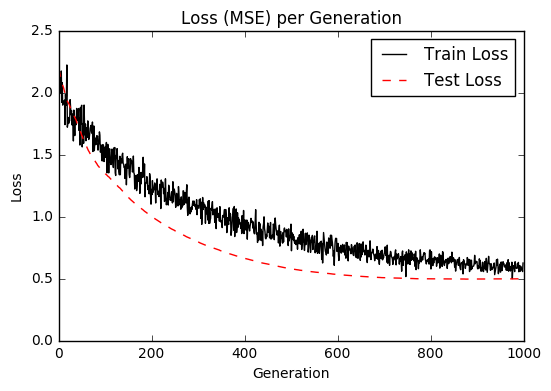

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.metrics import classification_report
 
ops.reset_default_graph()

def extract_data(filename):

    out = np.loadtxt(filename, delimiter=',');

    # Arrays to hold the labels and feature vectors.
    labels = out[:,0]
    labels = labels.reshape(labels.size,1)
    fvecs = out[:,1:]

    # Return a pair of the feature matrix and the one-hot label matrix.
    return fvecs,labels

def formulate_data(filename):

    # Extract data
    data, labels = extract_data(filename)

    # Get the shape
    size, num_features = data.shape

    return (data, labels, size, num_features)

train_data_filename = '../data/SPECT.train.txt'
test_data_filename = '../data/SPECT.test.txt'

train_data, train_labels, train_size, num_features = formulate_data(train_data_filename)
test_data, test_labels, test_size, num_features = formulate_data(test_data_filename)

# Create graph session 
sess = tf.Session()

# Declare batch size
batch_size = 50

# Initialize placeholders
xData = tf.placeholder(shape=[None, 22], dtype=tf.float32)
yLabels = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Number of hidden nodes
hidden_layer1_nodes = 5
hidden_layer2_nodes = 2

# Hidden layer1
W1 = tf.Variable(tf.random_normal(shape=[22,hidden_layer1_nodes]))
b1 = tf.Variable(tf.random_normal(shape=[hidden_layer1_nodes]))

# Hidden layer2
W2 = tf.Variable(tf.random_normal(shape=[hidden_layer1_nodes,hidden_layer2_nodes]))
b2 = tf.Variable(tf.random_normal(shape=[hidden_layer2_nodes]))

# Output layer
W3 = tf.Variable(tf.random_normal(shape=[hidden_layer2_nodes,1]))
b3 = tf.Variable(tf.random_normal(shape=[1]))

# Build model
hidden_layer1_output = tf.nn.relu(tf.add(tf.matmul(xData, W1), b1))
hidden_layer2_output = tf.nn.relu(tf.add(tf.matmul(hidden_layer1_output, W2), b2))
final_output = tf.nn.relu(tf.add(tf.matmul(hidden_layer2_output, W3), b3))

# Calculate Minimum Square Error
loss = tf.reduce_mean(tf.square(yLabels - final_output))

# Declare optimizer
learning_rate = 0.001
training_epochs = 1000
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
test_loss = []

for epoch in xrange(training_epochs):

    # Randomize
    rand_index = np.random.choice(len(train_data), size=batch_size)
    rand_x = train_data[rand_index]
    rand_y = train_labels[rand_index]

    # Training
    sess.run(optimizer, feed_dict={xData: rand_x, yLabels: rand_y})

    temp_loss = sess.run(loss, feed_dict={xData: rand_x, yLabels: rand_y})
    loss_vec.append(np.sqrt(temp_loss))
    
    # Testing
    test_temp_loss = sess.run(loss, feed_dict={xData: test_data, yLabels: test_labels})
    test_loss.append(np.sqrt(test_temp_loss))

predicted = sess.run(final_output, feed_dict={xData: test_data})
predicted[predicted!=0] = 1
# print predicted.T
print classification_report(test_labels, predicted)

# Calculate Sensitivity & Specificity
conMatrix = confusion_matrix(test_labels, predicted)
Sensitivity = conMatrix[0,0] * 1.0 / (conMatrix[0,0] + conMatrix[0,1])
Specificity = conMatrix[1,1] * 1.0 / (conMatrix[1,0] + conMatrix[1,1])

#print conMatrix

print "Sensitivity is %.3f" % Sensitivity
print "Specificity is %.3f" % Specificity

# Plot loss (MSE) over time
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.legend(loc='upper right')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

Because the data are relatively scarce, the performance is not perfect as expected.